In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
! pip install polars

Defaulting to user installation because normal site-packages is not writeable
  Using cached polars-1.35.2-py3-none-any.whl.metadata (10 kB)
  Using cached polars_runtime_32-1.35.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached polars-1.35.2-py3-none-any.whl (783 kB)
Using cached polars_runtime_32-1.35.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.3 MB)


In [2]:
import polars as pl
import matplotlib.pyplot as plt
from primary.preprocessing import cluster_purity, particle_purity
import plotly.express as px
import numpy as np
from primary.pdg_mappings import PDG_ID_TO_NAME

import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from collections import defaultdict, deque

/usr/wipp/conda/24.5.0u/envs/common/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.sparse import csr_matrix, issparse


In [2]:
from datasets import load_dataset
cache_dir = "/storage/agrp/barakma/hg_cache"
# Load first 100 rows of each configuration
particles = load_dataset("OpenDataDetector/ColliderML-Release-1", "ttbar_pu0_particles", split="train[:100]", cache_dir=cache_dir)
print(f"Loaded {len(particles)} particle events")

#tracker_hits = load_dataset("OpenDataDetector/ColliderML_ttbar_pu0", "tracker_hits", split="train[:100]")
calo_hits = load_dataset("OpenDataDetector/ColliderML-Release-1", "ttbar_pu0_calo_hits", split="train[:100]", cache_dir=cache_dir)
print(f"Loaded {len(calo_hits)} calo hit events")

tracks = load_dataset("OpenDataDetector/ColliderML-Release-1", "ttbar_pu0_tracks", split="train[:100]", cache_dir=cache_dir)

#print(f"Loaded {len(tracker_hits)} tracker hit events")
print(f"Loaded {len(tracks)} track events")


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/2700 [00:00<?, ?it/s]

ValueError: BuilderConfig 'ttbar_pu0_particles' not found. Available: ['default']

In [4]:
import polars as pl

particles = pl.read_parquet('hf://datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_particles/train-00000-of-00100.parquet')
calo_hits = pl.read_parquet('hf://datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_calo_hits/train-00000-of-00100.parquet')
tracks = pl.read_parquet('hf://datasets/OpenDataDetector/ColliderML-Release-1/data/ttbar_pu0_tracks/train-00000-of-00100.parquet')


In [9]:
particles

event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary
u32,list[u64],list[i64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[u16],list[i64],list[bool]
0,"[76, 77, … 2033]","[213, -211, … 11]","[0.738762, 0.13957, … 0.000511]","[2491.611816, 489.566223, … 0.001127]","[1.0, -1.0, … -1.0]","[0.009162, 0.009162, … 246.824448]","[-0.003694, -0.003694, … 958.047424]","[196.070236, 196.070236, … 1920.47644]","[0.442453, 0.442453, … 7.283049]","[0.033283, -0.342658, … 0.000469]","[-0.117263, 0.317618, … 0.000247]","[2491.611816, 489.565979, … 0.000853]","[NaN, NaN, … NaN]","[NaN, NaN, … NaN]","[1, 1, … 1]","[9, 9, … 2019]","[true, true, … false]"
1,"[10, 11, … 2879]","[211, -211, … 22]","[0.13957, 0.13957, … 0.0]","[1935.443848, 28.814047, … 219.003906]","[1.0, -1.0, … 0.0]","[-0.023709, -0.023709, … -0.023674]","[0.010315, 0.010315, … 0.0104]","[106.12365, 106.12365, … 106.093628]","[0.150796, 0.150796, … 0.150897]","[-0.005252, 0.212135, … 0.319321]","[0.20687, -0.101696, … 0.635319]","[1935.443848, 28.81275, … -219.002762]","[NaN, NaN, … 0.0]","[NaN, NaN, … 0.0]","[1, 1, … 1]","[3, 3, … 80]","[true, true, … false]"
2,"[64, 65, … 3238]","[-523, 111, … 11]","[5.3252, 0.13498, … 0.000511]","[18.453094, 3.594066, … 0.000571]","[0.0, 0.0, … -1.0]","[-0.013339, -0.013339, … -570.805908]","[-0.005375, -0.005375, … -7.775224]","[49.383862, 49.383862, … -1297.380615]","[0.034972, 0.034972, … 17.113577]","[17.1297, 3.394495, … 0.000148]","[-2.952355, -0.652638, … -0.000167]","[3.164794, 0.974962, … 0.000124]","[-0.007563, -0.007797, … NaN]","[49.386089, 49.387272, … NaN]","[1, 1, … 1]","[9, 9, … 3236]","[true, true, … false]"
3,"[43, 44, … 4223]","[2212, 221, … 22]","[0.93827, 0.54785, … 0.0]","[22.615156, 25.405207, … 1.411551]","[1.0, 0.0, … 0.0]","[0.008929, 0.008929, … 0.008918]","[-0.012789, -0.012789, … -0.012747]","[61.058159, 61.058159, … 61.060375]","[-0.078921, -0.078921, … -0.078914]","[0.010547, -0.045738, … 0.0583]","[0.230913, 0.842978, … 0.008144]","[22.594501, 25.385263, … 1.410324]","[-0.009503, -0.008223, … -0.013858]","[62.267075, 61.456688, … 60.89101]","[1, 1, … 1]","[8, 8, … 136]","[true, true, … false]"
4,"[113, 114, … 2391]","[223, 211, … 11]","[0.780666, 0.13957, … 0.000511]","[144.329086, 1.095027, … 0.155885]","[0.0, 1.0, … -1.0]","[0.006297, 0.006297, … 1013.232483]","[0.01418, 0.01418, … -1325.503418]","[52.569878, 52.569878, … 1553.529907]","[-0.277733, -0.277733, … 7.379701]","[-0.278494, 0.021264, … 0.136147]","[0.013545, 0.021074, … -0.059275]","[144.326706, 1.085683, … 0.047438]","[0.0, 0.005636, … NaN]","[0.0, 52.045685, … NaN]","[1, 1, … 1]","[8, 8, … 2385]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
995,"[80, 81, … 5670]","[-321, 223, … -11]","[0.49368, 0.793777, … 0.000511]","[28.717169, 8.620346, … 0.260374]","[-1.0, 0.0, … 1.0]","[-0.006419, -0.006419, … -1176.356079]","[-0.011553, -0.011553, … 196.795258]","[-75.322754, -75.322754, … -661.632385]","[-0.380586, -0.380586, … 4.052543]","[-11.782568, -3.758275, … -0.230535]","[6.858037, 2.032827, … 0.038017]","[-25.269951, -7.44468, … -0.114902]","[0.013214, 0.013216, … NaN]","[-75.323242, -75.322495, … NaN]","[1, 1, … 1]","[9, 9, … 5661]","[true, true, … false]"
996,"[29, 30, … 6397]","[-211, 111, … 2212]","[0.13957, 0.13498, … 0.938272]","[1.356178, 0.223959, … 1.102562]","[-1.0, 0.0, … 1.0]","[-0.000957, -0.000957, … 600.37915]","[0.005772, 0.005772, … -1230.669067]","[-1.210217, -1.210217, … -918.520935]","[0.248371, 0.248371, … 5.886685]","[-0.174356, 0.102382, … 0.410453]","[0.433903, -0.041758, … -0.277228]","[1.265332, 0.1404, … -0.299936]","[-0.001264, 0.004983, … NaN]","[-1.225674, -1.206324, … NaN]","[1, 1, … 1]","[9, 9, … 6389]","[true, true, … false]"
997,"[145, 146, … 8076]","[221, 111, … 11]","[0.54785, 0.13498, … 0.000511]","[2.467179, 0.135171, … 0.113213]","[0.0, 0.0, … -1.

Processing first 100 events for histogram...


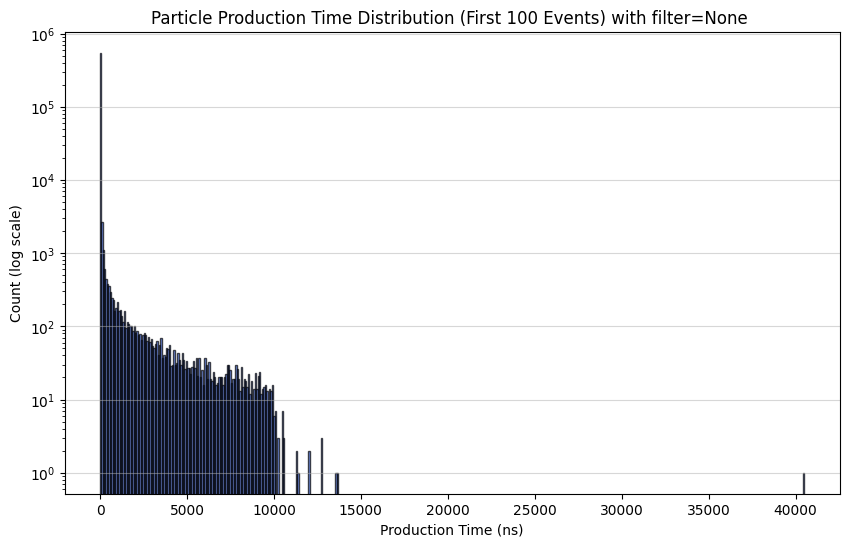

Total particles plotted: 558678
Mean time: 45.8918 ns
Max time:  40512.1602 ns


In [5]:
from primary.plot import plot_production_time_histogram
plot_production_time_histogram(memory_datasets['particles'], n_events=100, bins=500, log_scale=True)

In [5]:
from primary.preprocessing import add_orphan_mask, cast_parent_id_to_int64
#particles = cast_parent_id_to_int64(particles)
particles = add_orphan_mask(particles)

Computing parent existence mask...


In [33]:
event_idx = 0
indices = (particles[event_idx]['is_parent_missing'][0] == True).arg_true()
print(indices)


shape: (80,)
Series: '' [u32]
[
	0
	1
	2
	3
	4
	…
	153
	154
	155
	174
	175
]


In [6]:
from primary.preprocessing import get_mask_confusion_matrix
get_mask_confusion_matrix(particles, 'primary', 'is_parent_missing')

Comparing 'primary' vs 'is_parent_missing'...

--- Comparison Report: primary vs is_parent_missing ---
Intersection (Both True): 155,285
Only in primary:       218,280
Only in is_parent_missing:       0
Both False:             4,977,711
Both equal (True+False),   5,132,996,percentage: 95.92%
------------------------------


both_true,a_only,b_only,both_false
u32,u32,u32,u32
155285,218280,0,4977711


In [7]:
from primary.preprocessing import map_to_ultimate_ancestor_with_inherited_mask
particles_with_lineage = map_to_ultimate_ancestor_with_inherited_mask(particles)
particles_with_lineage

Preparing data & calculating masks...
Converged after 5 iterations.


event_id,particle_id,ultimate_ancestor_id,ancestor_created_inside_calo
u32,i64,i64,bool
21,295,188,false
149,4706,924,false
93,1127,215,false
455,4584,1037,false
215,6152,539,false
…,…,…,…
397,6285,1039,false
308,903,850,false
700,5907,1037,false


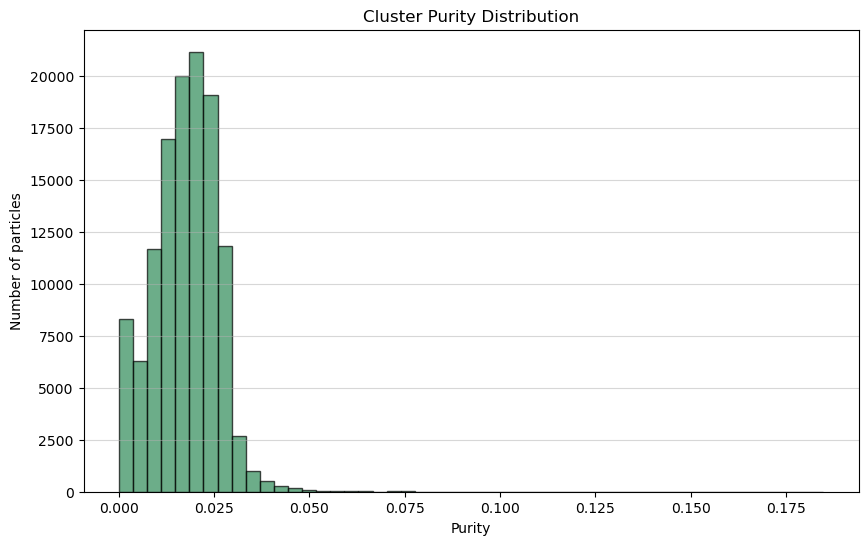

In [8]:
from primary.preprocessing import particle_purity
#p =particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)
from primary.plot import plot_particle_purity
plot_particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)

In [9]:
from primary.plot import plot_3d_particle_hierarchy
import plotly.io as pio
# This forces Plotly to embed the JS data directly in the cell output
# which helps it survive the SSH transfer to your local screen.
#pio.renderers.default = "notebook"
plot_3d_particle_hierarchy(particles=particles, calo_hits=calo_hits, event_idx=0)

In [12]:
p.sort("purity", descending=True).head(10)

NameError: name 'p' is not defined

In [ ]:
with pl.Config(tbl_rows=-1):

    print(
        particles.lazy()
        .select('primary', 'is_parent_missing', 'pdg_id')
        .explode(['primary', 'is_parent_missing', 'pdg_id'])
        .filter((pl.col('primary') & ~pl.col('is_parent_missing')))
        .select('pdg_id')
        .group_by('pdg_id')
        .len()
        .sort('len', descending=True)
        .head(10)
        .collect()  
    )

shape: (10, 2)
┌────────┬───────┐
│ pdg_id ┆ len   │
│ ---    ┆ ---   │
│ i64    ┆ u32   │
╞════════╪═══════╡
│ 111    ┆ 55591 │
│ 211    ┆ 47254 │
│ -211   ┆ 46884 │
│ 22     ┆ 11389 │
│ 310    ┆ 7850  │
│ 130    ┆ 7554  │
│ 321    ┆ 3845  │
│ -321   ┆ 3772  │
│ -311   ┆ 3200  │
│ 311    ┆ 3184  │
└────────┴───────┘


In [24]:
with pl.Config(tbl_rows=-1):
    print(
        particles.lazy()
        .select('primary','event_id', 'is_parent_missing', 'pdg_id', 'parent_id') # this is A
        .explode(['primary', 'is_parent_missing', 'pdg_id', 'parent_id'])
        .filter((pl.col('primary') & ~pl.col('is_parent_missing')))
        .select('pdg_id','event_id', 'parent_id')
        .join(
                (
                    particles.lazy()
                    .select('particle_id', 'pdg_id', 'event_id')
                    .rename({'particle_id': 'particle_id', 'pdg_id': 'parent_pdg_id', 'event_id': 'event_id'})
                    .explode('particle_id', 'parent_pdg_id')),
            left_on=['parent_id', 'event_id'],
            right_on=['particle_id', 'event_id'],
            how='left',
        )

        .group_by('pdg_id', 'parent_pdg_id')
        .len()
        .sort('len', descending=True)
        .head(20)
        .collect()  
    )

shape: (20, 3)
┌────────┬───────────────┬───────┐
│ pdg_id ┆ parent_pdg_id ┆ len   │
│ ---    ┆ ---           ┆ ---   │
│ i64    ┆ i64           ┆ u32   │
╞════════╪═══════════════╪═══════╡
│ 111    ┆ 221           ┆ 10306 │
│ -211   ┆ 113           ┆ 10162 │
│ 211    ┆ 113           ┆ 10162 │
│ 211    ┆ 213           ┆ 9864  │
│ 111    ┆ 213           ┆ 9853  │
│ 111    ┆ 223           ┆ 9782  │
│ -211   ┆ -213          ┆ 9593  │
│ 111    ┆ -213          ┆ 9591  │
│ 211    ┆ 223           ┆ 9096  │
│ -211   ┆ 223           ┆ 9096  │
│ 22     ┆ 221           ┆ 7142  │
│ 211    ┆ 310           ┆ 5414  │
│ -211   ┆ 310           ┆ 5414  │
│ 111    ┆ 310           ┆ 4868  │
│ 310    ┆ -311          ┆ 3790  │
│ 310    ┆ 311           ┆ 3755  │
│ 130    ┆ 311           ┆ 3628  │
│ 130    ┆ -311          ┆ 3617  │
│ -211   ┆ 221           ┆ 2384  │
│ 211    ┆ 221           ┆ 2384  │
└────────┴───────────────┴───────┘


In [5]:
from primary.preprocessing import map_to_ultimate_ancestor_with_inherited_mask
particles_with_lineage = map_to_ultimate_ancestor_with_inherited_mask(particles)


Preparing data & calculating masks...
Converged after 5 iterations.


In [6]:
from primary.preprocessing import particle_purity
particles_with_purity = particle_purity(calo_hits=calo_hits,ancestors=particles_with_lineage, particles=particles)
particles_with_purity

event_id,ultimate_ancestor_id,total_energy_in_calo,total_particle_energy,purity
u32,i64,f32,f32,f32
640,328,0.020479,0.930543,0.022008
640,343,0.192252,8.651638,0.022221
640,546,0.075578,7.356803,0.010273
640,554,0.073349,3.704378,0.019801
641,207,0.010703,1.119498,0.009561
…,…,…,…,…
831,943,0.109881,5.762229,0.019069
831,963,0.238694,8.525401,0.027998
831,1030,1.918916,76.551346,0.025067


Processing first 100 events for histogram...


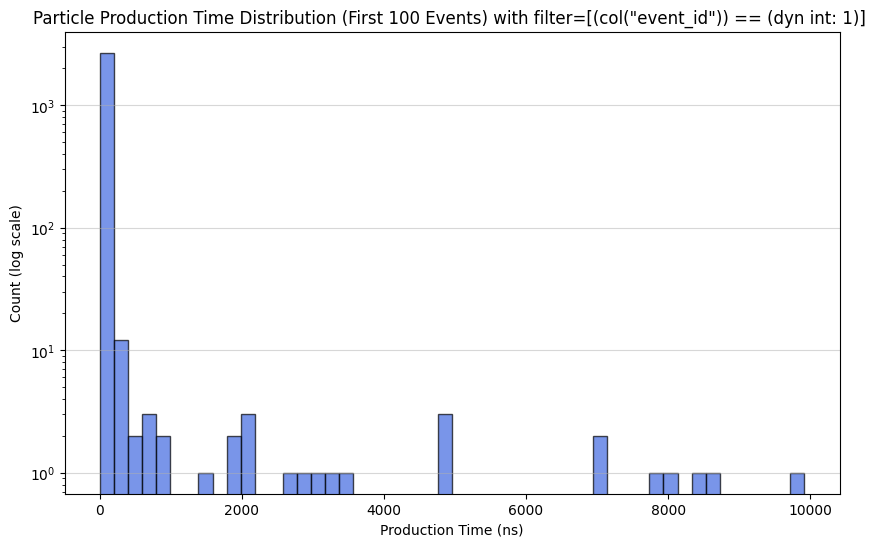

Total particles plotted: 2719
Mean time: 47.4903 ns
Max time:  9918.4180 ns


In [4]:
import polars as pl

from primary.plot import plot_production_time_histogram
plot_production_time_histogram(particles, n_events=100, bins=50, log_scale=True, filter_expression=pl.col("event_id") == 1)#

In [7]:
from primary.plot import plot_ancestor_distribution
plot_ancestor_distribution(particles_with_lineage)

ModuleNotFoundError: No module named 'plotly.io'

In [29]:
(
particles.lazy()
.select('event_id','particle_id')
.explode('particle_id')
.join(
    particles_with_lineage.lazy().select('event_idx','ultimate_ancestor_id').unique(),
    left_on=["event_id", "particle_id"], 
    right_on=["event_idx", "ultimate_ancestor_id"],
    how="inner",
)
.unique()
.collect()
)



event_id,particle_id
u32,u64


In [75]:
event_idx = 7
from primary.preprocessing import run_meanshift
calo_event_with_clusters = run_meanshift(event_idx, calo_hits, bandwidth=500)
# cluster count
cluster_count = calo_event_with_clusters.select("cluster_id").explode('cluster_id').n_unique()
print(f"Event {event_idx} has {cluster_count} clusters identified by MeanShift.")

Event 7 has 51 clusters identified by MeanShift.


In [56]:
calo_event_with_clusters

event_id,detector,total_energy,x,y,z,contrib_particle_ids,contrib_energies,contrib_times,cluster_id,cluster_cx,cluster_cy,cluster_cz
u32,list[u8],list[f32],list[f32],list[f32],list[f32],list[list[u64]],list[list[f32]],list[list[f32]],"array[i32, 12553]","array[f32, 12553]","array[f32, 12553]","array[f32, 12553]"
4,"[11, 10, … 10]","[0.000199, 0.000092, … 0.000146]","[-243.458908, 1101.495605, … 1234.614624]","[-374.530731, -762.508606, … 384.429535]","[3242.800049, 1116.900024, … 2529.600098]","[[1876], [2192], … [1957]]","[[0.000199], [0.000092], … [0.000146]]","[[12.287476], [5.514093], … [9.358251]]","[0, 0, … 0]","[335.154724, 335.154724, … 335.154724]","[306.335144, 306.335144, … 306.335144]","[1244.026855, 1244.026855, … 1244.026855]"


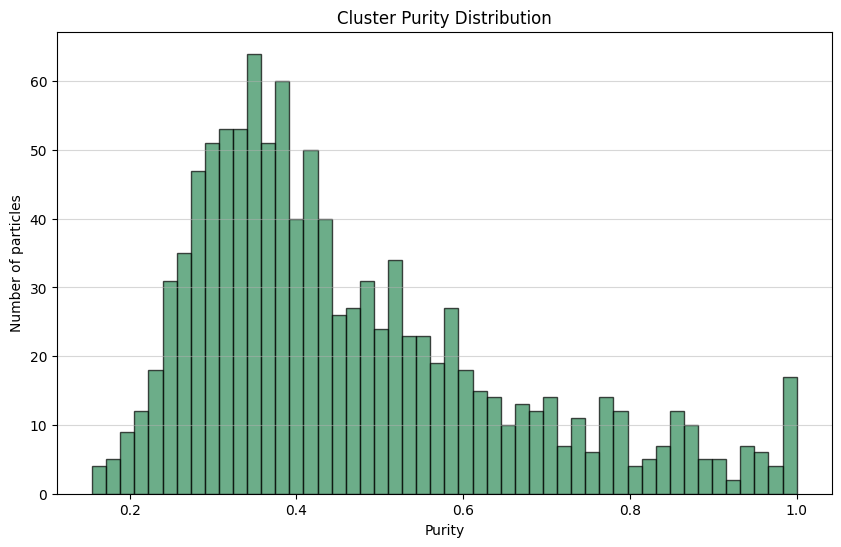

In [76]:
from primary.plot import plot_purity
plot_purity(calo_event_with_clusters, particles_with_lineage)

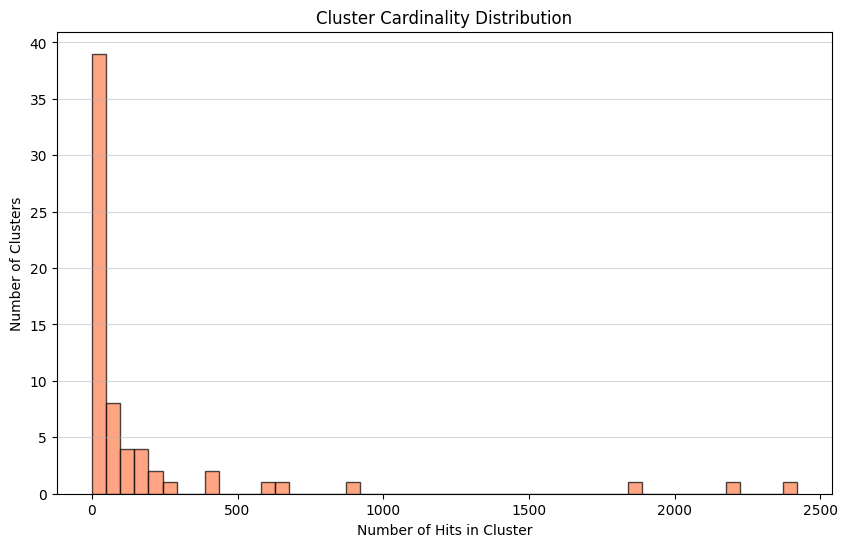

In [70]:
from primary.plot import plot_cluster_cardinallity
plot_cluster_cardinallity(calo_event_with_clusters)

In [ ]:
memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][5]

parent_id
list[f64]
"[9.0, 9.0, … null]"


In [7]:
particle_ids = particles[5]['particle_id'][0]
parent_ids = particles[5]['parent_id'][0]
particles_time = particles[5]['time'][0]
index = (particle_ids == 1150).arg_true().to_list()[0]
print(index)
parent_exact_id = parent_ids[index] 
particle_time = particles_time[index]
print(parent_exact_id)
parent_index = (particle_ids == parent_exact_id).arg_true().to_list()[0]
parent_time = particles_time[parent_index]
print(parent_index)
parent_parent_id = parent_ids[parent_index]
print(parent_parent_id)
print(f"Summary: Particle {particle_ids[index]}, index: {index}, creation time: {particle_time} has parent {parent_exact_id}, parent_index: {parent_index}, parent creation time: {parent_time} whose parent is {parent_parent_id}")

493
1153.0
496
1150.0
Summary: Particle 1150, index: 493, creation time: 2.123812437057495 has parent 1153.0, parent_index: 496, parent creation time: 4.163594722747803 whose parent is 1150.0


In [17]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
# select particle_id,event_id
result = (
    exploded.select(["event_id", "particle_id"])
)
result

event_id,particle_id
i64,i64
0,76
0,77
0,78
0,79
0,80
…,…
9,6966
9,6967
9,6968


In [16]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
result = (
    exploded.group_by(["event_id", "particle_id"])
            .agg(pl.len().alias("count"))
          
)
result

event_id,particle_id,count
i64,i64,u32
1,2399,1
0,964,1
8,2672,1
7,6269,1
7,2721,1
…,…,…
6,5374,1
5,5216,1
6,1817,1


In [14]:
particles

event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,vertex_primary,parent_id,is_parent_missing
i64,list[i64],list[i64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[i64],list[i64],list[bool]
0,"[76, 77, … 1977]","[213, -211, … 2212]","[0.738762, 0.13957, … 0.938272]","[2491.611858, 489.56621, … 1.464839]","[1.0, -1.0, … 1.0]","[0.009162, 0.009162, … 2159.469482]","[-0.003694, -0.003694, … 1843.329346]","[196.070236, 196.070236, … -210.282364]","[11.958187, 11.958187, … 22.085659]","[0.033283, -0.342658, … 0.853529]","[-0.117263, 0.317618, … 0.710063]","[2491.611816, 489.565979, … 0.180822]","[1, 1, … 1]","[9, 9, … 1976]","[true, true, … false]"
1,"[10, 11, … 2692]","[211, -211, … 22]","[0.13957, 0.13957, … 0.0]","[1935.443866, 28.814048, … 222.092745]","[1.0, -1.0, … 0.0]","[-0.023709, -0.023709, … -0.023614]","[0.010315, 0.010315, … 0.010545]","[106.12365, 106.12365, … 106.042526]","[4.075578, 4.075578, … 4.075848]","[-0.005252, 0.212135, … 0.30518]","[0.20687, -0.101696, … 0.58315]","[1935.443848, 28.81275, … -222.091766]","[1, 1, … 1]","[3, 3, … 80]","[true, true, … false]"
2,"[64, 65, … 3226]","[-523, 111, … -11]","[5.3252, 0.13498, … 0.000511]","[18.453095, 3.594066, … 0.362266]","[0.0, 0.0, … 1.0]","[-0.013339, -0.013339, … 16.921406]","[-0.005375, -0.005375, … 1308.693481]","[49.383862, 49.383862, … -1014.986938]","[0.945178, 0.945178, … 6.572384]","[17.1297, 3.394495, … 0.009029]","[-2.952355, -0.652638, … 0.275271]","[3.164794, 0.974962, … -0.235331]","[1, 1, … 1]","[9, 9, … 3213]","[true, true, … false]"
3,"[43, 44, … 4354]","[2212, 221, … 22]","[0.93827, 0.54785, … 0.0]","[22.615156, 25.405206, … 2.882969]","[1.0, 0.0, … 0.0]","[0.008929, 0.008929, … 0.008919]","[-0.012789, -0.012789, … -0.012751]","[61.058159, 61.058159, … 61.060184]","[-2.133011, -2.133011, … -2.133004]","[0.010547, -0.045738, … -0.013601]","[0.230913, 0.842978, … 0.074248]","[22.594501, 25.385263, … 2.881981]","[1, 1, … 1]","[8, 8, … 136]","[true, true, … false]"
4,"[113, 114, … 2269]","[223, 211, … 11]","[0.780666, 0.13957, … 0.000511]","[144.329089, 1.095027, … 0.139602]","[0.0, 1.0, … -1.0]","[0.006297, 0.006297, … 789.904236]","[0.01418, 0.01418, … -1050.674683]","[52.569878, 52.569878, … 1126.600952]","[-7.506285, -7.506285, … -1.779469]","[-0.278494, 0.021264, … 0.017909]","[0.013545, 0.021074, … -0.108077]","[144.326706, 1.085683, … 0.086528]","[1, 1, … 1]","[8, 8, … 2263]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
995,"[80, 81, … 5640]","[-321, 223, … 11]","[0.49368, 0.793777, … 0.000511]","[28.717168, 8.620346, … 0.000618]","[-1.0, 0.0, … -1.0]","[-0.006419, -0.006419, … 657.985657]","[-0.011553, -0.011553, … -44.434826]","[-75.322754, -75.322754, … -896.249573]","[-10.286097, -10.286097, … 0.747436]","[-11.782568, -3.758275, … 0.000138]","[6.858037, 2.032827, … -0.000308]","[-25.269951, -7.44468, … -0.000084]","[1, 1, … 1]","[9, 9, … 5639]","[true, true, … false]"
996,"[29, 30, … 6055]","[-211, 111, … 211]","[0.13957, 0.13498, … 0.1395701]","[1.356178, 0.223959, … 0.394234]","[-1.0, 0.0, … 1.0]","[-0.000957, -0.000957, … 764.739319]","[0.005772, 0.005772, … -1481.490234]","[-1.210217, -1.210217, … -1178.932739]","[6.712732, 6.712732, … 13.60649]","[-0.174356, 0.102382, … -0.072125]","[0.433903, -0.041758, … -0.34707]","[1.265332, 0.1404, … -0.101396]","[1, 1, … 1]","[9, 9, … 6054]","[true, true, … false]"
997,"[145, 146, … 7849]","[221, 111, … 11]","[0.54785, 0.13498, … 0.000511]","[2.467179, 0.135171, … 0.000517]","[0.0, 0.0, … -1.0]","[0.009254, 0.009254, … 428.086304]","[-0.000325, -0.000325, … -501.950165]","[86.061668, 86.061668, … 1074.772827]","[8.644897, 8.644897, … 20.044153]","[1.394695, -0.006932, … -0.000056]","[0.625924, 0.001811, … 0.000044]","[1.857385, 0.000576, … -0.000033]","[1, 1, … 1]","[8, 8, … 7842]","[true, true, … false]"


In [ ]:
import pandas as pd

def get_ancestors_with_cycle_detection(ids, parent_ids):
    # 1. Fast lookup map
    parent_map = dict(zip(ids, parent_ids))
    
    # 2. Memoization dictionary to store final root for every ID
    #    If a node is part of a cycle, we map it to None (or a specific flag)
    #    to prevent infinite loops in future lookups.
    ancestors = {}

    for node in ids:
        # If already calculated, skip
        if node in ancestors:
            continue

        path = []
        path_set = set() # For O(1) cycle checking
        curr = node
        
        root_found = None
        
        while True:
            # Add current node to path
            path.append(curr)
            path_set.add(curr)
            
            # Get parent
            parent = parent_map.get(curr)

            # --- END CONDITION 1: Natural Root (None) ---
            if parent is None:
                root_found = curr
                break
            
            # --- END CONDITION 2: Self-Loop ---
            if parent == curr:
                # Technically a cycle, usually treated as a root in this context
                root_found = curr
                break

            # --- END CONDITION 3: Hit a previously calculated node ---
            if parent in ancestors:
                root_found = ancestors[parent]
                break

            # --- END CONDITION 4: Cycle Detected (Loop) ---
            if parent in path_set:
                # We found a cycle. 
                # Let's extract exactly which nodes are looping.
                cycle_start_index = path.index(parent)
                cycle_nodes = path[cycle_start_index:]
                
                # Print the cycle
                print(f"Cycle Detected: {' -> '.join(map(str, cycle_nodes))} -> {parent}")
                
                # We define the 'root' of a cycle as None (or you could mark it as "Cycle")
                root_found = None 
                break
            
            # Move up
            curr = parent
        
        # --- Path Compression ---
        # Assign the found result to everyone in the path so we never process them again.
        for p in path:
            ancestors[p] = root_found

    return ancestors

# Usage
df = pd.DataFrame({'id': particles[5]['particle_id'][0].to_list(), 'parent_id': particles[5]['parent_id'][0].to_list()})
df['root_id'] = get_ancestors_with_cycle_detection(df['id'], df['parent_id'])
print(df)

Cycle Detected: 1150.0 -> 1153.0 -> 1150.0
Cycle Detected: 1160 -> 1161.0 -> 1160.0
Cycle Detected: 1228.0 -> 1230.0 -> 1228.0
Cycle Detected: 1259.0 -> 1262.0 -> 1259.0
Cycle Detected: 1268.0 -> 1265.0 -> 1268.0
Cycle Detected: 1325.0 -> 1322.0 -> 1325.0
Cycle Detected: 1359.0 -> 1361.0 -> 1359.0
Cycle Detected: 1460.0 -> 1461.0 -> 1460.0
Cycle Detected: 1481.0 -> 1484.0 -> 1487.0 -> 1490.0 -> 1480.0 -> 1481.0
Cycle Detected: 1587.0 -> 1586.0 -> 1587.0
Cycle Detected: 1602.0 -> 1605.0 -> 1602.0
Cycle Detected: 1627.0 -> 1630.0 -> 1627.0
Cycle Detected: 1728.0 -> 1727.0 -> 1728.0
Cycle Detected: 1740.0 -> 1739.0 -> 1740.0
Cycle Detected: 1767.0 -> 1770.0 -> 1766.0 -> 1769.0 -> 1768.0 -> 1771.0 -> 1765.0 -> 1767.0
Cycle Detected: 1803.0 -> 1806.0 -> 1803.0
Cycle Detected: 1889.0 -> 1888.0 -> 1889.0
Cycle Detected: 1900.0 -> 1899.0 -> 1901.0 -> 1898.0 -> 1900.0
Cycle Detected: 1921.0 -> 1922.0 -> 1921.0
Cycle Detected: 1957 -> 1960.0 -> 1957.0
Cycle Detected: 1985.0 -> 1988.0 -> 1985.0
C

ValueError: cannot reindex on an axis with duplicate labels